<a href="https://colab.research.google.com/github/ViktorAnchutin/miniresnet/blob/main/mini_resnet_from_scratch_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a mini resnet from scratch for rice disease classification

![](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/paddy.png?raw=true)
![](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/1%20Model.png?raw=true)

One epoch training time: 18 seconds

Number of parameters: ~0.5M

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torchvision import transforms
import gc
from functools import partial
from tqdm import tqdm
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Convolution block
It is a basic building block of the model. It takes the number of input channels/features and produces the output volume with the specified number of channels. The block of 3x3 convolutional filters is followed by a batch norm and an activation fuction.
By default the padding is equal to 1 so that the 3x3 convolutions don't reduce the size of the input. The same block is used in the [resnet](https://arxiv.org/abs/1512.03385) and the [batch norm](https://arxiv.org/pdf/1502.03167.pdf) papers
![](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/3%20resnet%20paper.png?raw=true)

In [2]:
def convolution_block(input_ch, output_ch, kernel_size = 3, padding=1, act=True):
    layers = [nn.Conv2d(input_ch, output_ch, stride=1, kernel_size=kernel_size, padding=padding), nn.BatchNorm2d(output_ch)]
    if act: layers.append(nn.LeakyReLU(0.1))
    return nn.Sequential(*layers)

# Example, channels 3 -> 32
convolution_block(input_ch=3,output_ch=32)(torch.randn((64,3,244,244))).shape

torch.Size([64, 32, 244, 244])

## Residual module

I use a simple residual module without downsampling, which contains 2 consecutive convolutional blocks and a residual connection. In case the number of input and output channels are different a 1x1 conolutional block is used to match the number of channles in the residual connection
![](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/4%20resnet%20block.png?raw=true)


From the resnet [paper](https://arxiv.org/abs/1512.03385):

![](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/5%20resnet%20paper.png?raw=true)

In [3]:
class ResidualBlock(nn.Module):
  def __init__(self, input_ch, output_ch):
    super(ResidualBlock, self).__init__()
    self.noop = lambda x: x
    self.residual_conv = convolution_block(input_ch,output_ch,kernel_size=1, padding=0, act=False)
    self.residual_connection = self.noop if input_ch == output_ch else self.residual_conv
    self.conv1 = convolution_block(input_ch,output_ch)
    self.conv2 = convolution_block(output_ch,output_ch,act=False)
    self.convolutions = lambda x: self.conv2(self.conv1(x))
    self.relu = nn.LeakyReLU(0.1)
  def forward(self, x):
    return self.relu(self.convolutions(x) + self.residual_connection(x))

ResidualBlock(3,32)(torch.randn((64,3,244,244))).shape, ResidualBlock(32,32)(torch.randn((64,32,244,244))).shape

(torch.Size([64, 32, 244, 244]), torch.Size([64, 32, 244, 244]))

## MaxPooling
The downsampling of the input can be performed with strided convolutions or by using polling. They have they pros and cons, I choose maxpooling, that way the model needs to learn less parameters.
![](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/6%20max%20pooling.png?raw=true)

In [4]:
nn.MaxPool2d(2)(torch.randn((64,3,144,144))).shape, nn.MaxPool2d(2)(torch.randn((64,3,7,7))).shape

(torch.Size([64, 3, 72, 72]), torch.Size([64, 3, 3, 3]))

## Global average pooling

This layer essentially turns each feature map into a single number by averaging all the values. It allows to use different size inputs.


![](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/7%20gap.png?raw=true)

In [5]:
nn.AdaptiveAvgPool2d((1,1))(torch.randn((64,128,7,7))).shape, nn.AdaptiveAvgPool2d((1,1))(torch.randn((64,256,2,2))).shape

(torch.Size([64, 128, 1, 1]), torch.Size([64, 256, 1, 1]))

## Flatten layer

After the global average pooling the dimention of the tensor would be (Batch x Channels x 1 x 1). To feed it into the fully connected layer we need to flatten it to (Batch x Channels). But in general flattening operation should be able to strech N dimentional trensor into 1D tensor.


![image.png](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/8%20flatten.png?raw=true)

In [6]:
class FlattenLayer(nn.Module):
  def __init__(self): super(FlattenLayer, self).__init__()
  def forward(self, x):
    return x.view(x.size(0), -1)

FlattenLayer()(torch.randn((64,128,1,1))).shape,  FlattenLayer()(torch.randn((64,3,3,3))).shape

(torch.Size([64, 128]), torch.Size([64, 27]))

## Classification head

The last module is a 2 layer feed forward network with activation function in between. The classificatoin head maps the N dimentional input feature vector to a 10 dimentional output vector, which represents the predicted logits for each class.

![image.png](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/9%20head.png?raw=true)

## Building the model

In [7]:
def get_model():
  return nn.Sequential(
      convolution_block(3,32),
      nn.MaxPool2d(2),
      ResidualBlock(32, 32),
      nn.MaxPool2d(2),
      ResidualBlock(32, 32),
      nn.MaxPool2d(2),
      ResidualBlock(32, 64),
      nn.MaxPool2d(2),
      ResidualBlock(64, 64),
      nn.MaxPool2d(2),
      ResidualBlock(64, 64),
      nn.MaxPool2d(2),
      ResidualBlock(64, 128),
      nn.AdaptiveAvgPool2d((1,1)),
      FlattenLayer(),
      nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 10)
  )


get_model()(torch.randn(64,3,244,244)).shape

torch.Size([64, 10])

### Check data dimensions

In [8]:
shapes = []
model = get_model()
input = torch.randn(64,3,244,244)
for layer in model:
    layer.register_forward_hook(lambda module,args,output: shapes.append((type(module), list(output.shape))))
model(input);
pd.DataFrame(shapes, columns=['module', 'output'])

,module,output
0,<class 'torch.nn.modules.container.Sequential'>,"[64, 32, 244, 244]"
1,<class 'torch.nn.modules.pooling.MaxPool2d'>,"[64, 32, 122, 122]"
2,<class '__main__.ResidualBlock'>,"[64, 32, 122, 122]"
3,<class 'torch.nn.modules.pooling.MaxPool2d'>,"[64, 32, 61, 61]"
4,<class '__main__.ResidualBlock'>,"[64, 32, 61, 61]"
5,<class 'torch.nn.modules.pooling.MaxPool2d'>,"[64, 32, 30, 30]"
6,<class '__main__.ResidualBlock'>,"[64, 64, 30, 30]"
7,<class 'torch.nn.modules.pooling.MaxPool2d'>,"[64, 64, 15, 15]"
8,<class '__main__.ResidualBlock'>,"[64, 64, 15, 15]"
9,<class 'torch.nn.modules.pooling.MaxPool2d'>,"[64, 64, 7, 7]"


## Download data

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ #  kaggle personal token json file
! chmod 600 ~/.kaggle/kaggle.json


!kaggle competitions download -c paddy-disease-classification

!unzip /content/paddy-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

## Prepare data

In [11]:
data_path = 'train_images'


def get_imgs_into():
  train_folders = list((Path(data_path)).iterdir())
  images = [(img_path.name, img_folder.name, Image.open(img_path).size) for img_folder in tqdm(train_folders,position=0) for img_path in img_folder.iterdir()]
  images = pd.DataFrame(data = images, columns=["id", "label", "size"])
  return images
imgs_info = get_imgs_into()
imgs_info

100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


,id,label,size
0,108706.jpg,bacterial_panicle_blight,"(480, 640)"
1,104414.jpg,bacterial_panicle_blight,"(480, 640)"
2,106589.jpg,bacterial_panicle_blight,"(480, 640)"
3,108585.jpg,bacterial_panicle_blight,"(480, 640)"
4,102955.jpg,bacterial_panicle_blight,"(480, 640)"
...,...,...,...
10402,105986.jpg,hispa,"(480, 640)"
10403,104959.jpg,hispa,"(480, 640)"
10404,104619.jpg,hispa,"(480, 640)"
10405,104946.jpg,hispa,"(480, 640)"


### Labels distribution

<Axes: ylabel='label'>

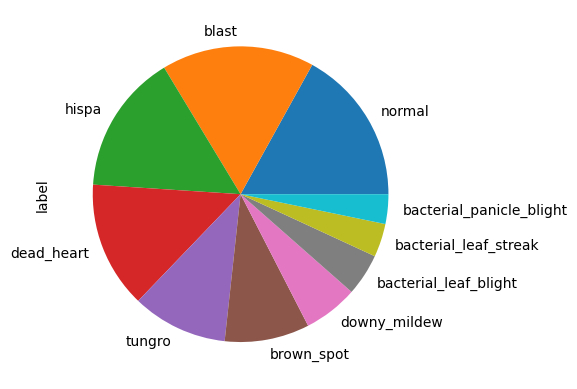

In [12]:
imgs_info.label.value_counts().plot.pie()

### Size of the images

In [13]:
imgs_info["size"].value_counts()

(480, 640)    10403
(640, 480)        4
Name: size, dtype: int64

### Reduce size
To accelerate experiments I reduced the size of the images to 244 x 244.
![image.png](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/10%20Resize.png?raw=true)

In [14]:
def resize_imgs(df, dest, size):
  for label_dir in df.label.unique():
    Path(f"{dest}/{label_dir}").mkdir(parents=True,exist_ok=True)
  for _, row in tqdm(list(df.iterrows())):
    label = row["label"]
    id = row["id"]
    im = Image.open(Path(data_path)/label/id)
    im.resize(size).save(f"{dest}/{label}/{id}")


sml_imgs_path = "train_sml"
resize_imgs(imgs_info, sml_imgs_path, (244,244))

100%|██████████| 10407/10407 [01:17<00:00, 134.83it/s]


### Split train/validation

<Axes: >

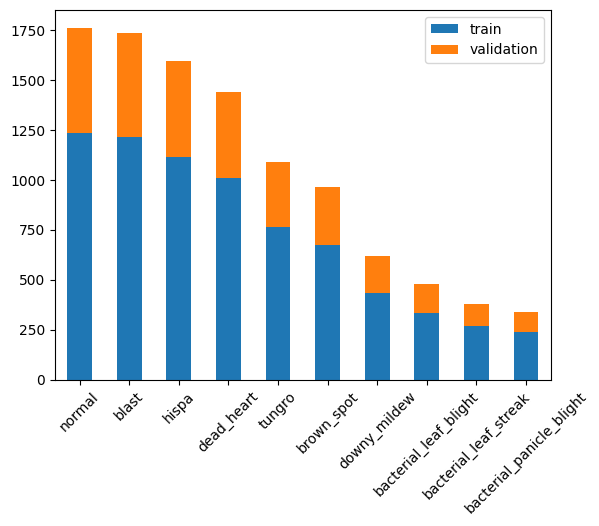

In [15]:
train_data = imgs_info.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=123))
valid_data = imgs_info.loc[~imgs_info.index.isin(train_data.index)]
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

pd.concat([
    train_data.label.value_counts().rename('train'),
    valid_data.label.value_counts().rename('validation')],
    axis=1)\
.plot.bar(stacked=True,rot=45)

### Label encoding

In [16]:
label_to_index = {label:id for id,label in enumerate(imgs_info.label.unique())}
label_to_index

{'bacterial_panicle_blight': 0,
 'brown_spot': 1,
 'downy_mildew': 2,
 'normal': 3,
 'blast': 4,
 'tungro': 5,
 'bacterial_leaf_streak': 6,
 'bacterial_leaf_blight': 7,
 'dead_heart': 8,
 'hispa': 9}

## Create dataset
![image.png](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/11%20dataset.png?raw=true)

In [17]:
class Dataset:
    def __init__(self,annotations,label_encoding,data_path):
        self.annotations = annotations
        self.label_encoding = label_encoding
        self.data_path = data_path
        self.transforms = transforms.Compose([Image.open, transforms.ToTensor()])
        self.prefetched_items = {}

    def __getitem__(self, index):
        item = self.prefetched_items.get(index, None)
        if item is None:
            annotation = self.annotations.iloc[index]
            path = f'{self.data_path}/{annotation.label}/{annotation.id}'
            x = self.transforms(path)
            y = self.label_encoding[annotation.label]
            item = (x,y)
        return item

    def __len__(self): return len(self.annotations)

    def prefetch(self, frac=1):
        n = int(len(self.annotations)*frac)
        self.prefetched_items = { id:self[id] for id in tqdm(range(n)) }


train_ds = Dataset(train_data,label_to_index,sml_imgs_path)
validation_ds = Dataset(valid_data,label_to_index,sml_imgs_path)

### Estimate mean and std

Estimating means and standart deviations for each channel in the train dataset.

In [18]:
means = []
stds = []

for id in tqdm(range(len(train_ds))):
    item = train_ds[id]
    mean = item[0].mean(dim=(1,2)) # C,H,W -> mean(H,W)
    std = item[0].std(dim=(1,2))
    means.append(mean)
    stds.append(std)

means = torch.stack(means).mean(0)
stds = torch.stack(stds).mean(0)

means,stds

100%|██████████| 7286/7286 [00:20<00:00, 353.95it/s]


(tensor([0.4962, 0.5876, 0.2331]), tensor([0.2214, 0.2233, 0.1802]))

# Training loop

Training loop is responsible for forward pass, backward pass and optimization step

![image.png](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/12%20%20training%20loop.png?raw=true)

In [19]:
from tqdm import tqdm
import functools
import math

class Listener:
    '''
        Callback interface for different stages of the training process
    '''
    def before_fit(self): pass
    def after_batch(self): pass
    def after_epoch(self): pass
    def before_epoch(self): pass
    def after_fit(self): pass


def call_all(listeners,method_name):
    for l in listeners:
        getattr(l,method_name)()

class ListenerList(Listener):
    '''
        Callback dispatcher, calls all the listeners
    '''
    def __init__(self, listeners, trainer):
        self.listeners = listeners
        for l in self.listeners: l.trainer = trainer

    def __getattribute__(self, attr):
      if hasattr(Listener, attr): # redirect call to all the listeners if the method is from Listener
        return functools.partial(call_all, self.listeners, attr)
      else:
        return object.__getattribute__(self, attr) # do not redirect the call


class Trainer:
  def __init__(self, model, train_dl, valid_dl, opt_func,
               lr, loss_func, callbacks=[]):
    self.model, self.train_dl, self.valid_dl, self.lr = model, train_dl, valid_dl, lr
    self.loss_func = loss_func
    self.opt_func = opt_func
    self.cbs = ListenerList(callbacks,self)
    self.model.to(device)

  def one_batch(self, xb, yb):
        self.yb = yb.to(device)
        self.xb = xb.to(device)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        self.cbs.after_batch()

  def one_epoch(self, train=True):
    self.model.training = train
    self.cbs.before_epoch()
    self.dl = self.train_dl if train else self.valid_dl
    for xb,yb in tqdm(self.dl, position=0, leave=True):
      self.one_batch(xb,yb)
    self.cbs.after_epoch()


  def fit(self, epochs):
      self.epochs = epochs
      self.opt = self.opt_func(self.model.parameters(), self.lr)
      self.cbs.before_fit()
      for e in range(epochs):
        self.epoch = e
        self.one_epoch()
        with torch.no_grad(): self.one_epoch(train=False)
      self.cbs.after_fit()

### Data normalization callback
![image.png](https://github.com/ViktorAnchutin/miniresnet/blob/main/rdc_images/13%20norm.png?raw=true)

This callback will perform data normalization so that each channel across all the images has zero mean and unit variance

In [20]:
class DataNorm(Listener):
  def __init__(self, mean, std, trainer=None):
    if trainer is not None: self.trainer = trainer
    self.mean = mean[None,:,None,None] # add dimensions to match B,C,H,W shape
    self.std = std[None,:,None,None]

  def _norm(self,x, data_mean, data_std):
      return (x - data_mean)/data_std

  def before_batch(self):
    self.trainer.batch.x = self._norm(self.trainer.batch.x, self.mean, self.std)

### Metrics

In [21]:
from collections import defaultdict
from statistics import mean

class EpochMetrics(Listener):
    '''
        Compute loss and accuracy metrics for each epoch
    '''
    def __init__(self, trainer=None):
      if trainer is not None: self.trainer = trainer

    def before_epoch(self):
        self.mode = 'train' if self.trainer.model.training else 'test'
        if self.mode == 'train':
          self.metrics = defaultdict(list)
          self.metrics['lr'].append(self.trainer.opt.param_groups[0]['lr'])

    @torch.no_grad()
    def after_batch(self):
        accuracy = (self.trainer.preds.argmax(dim=1)==self.trainer.yb).float().mean().detach().item()
        loss = self.trainer.loss.detach().item()
        self.metrics[f'{self.mode}_acc'].append(accuracy)
        self.metrics[f'{self.mode}_loss'].append(loss)

    def after_epoch(self):
      if self.mode == 'test':
        aggregated = {k:mean(v) for k,v in self.metrics.items()}
        display(pd.DataFrame(aggregated, index=[self.trainer.epoch]))

### Learnin rate scheduler

Reducing the learning rate during deep learning training is essential to strike a balance between fast convergence and stable optimization.

Initially using a higher learning rate facilitates rapid progress towards relevant areas of the loss surface, avoiding shallow local minima. However, as training proceeds, a reduced learning rate prevents overshooting and oscillations, enabling the optimization process to settle into a more refined solution.

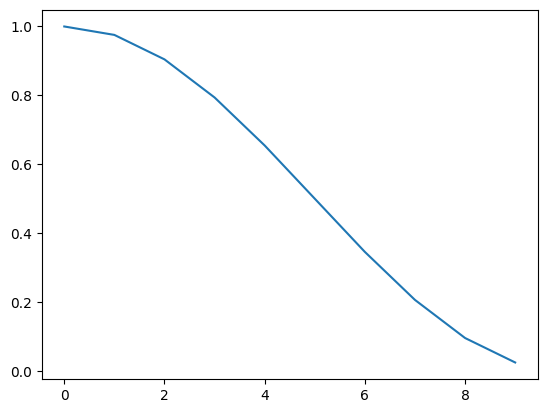

In [22]:
class LrScheduler(Listener):
  def __init__(self, sched, trainer=None):
    self.sched_func = sched
    if trainer is not None: self.trainer = trainer
  def before_fit(self):
    self.sched = self.sched_func(self.trainer.opt)
  def after_epoch(self):
     if self.trainer.model.training: self.sched.step()


class CosineLRCalculator:
  def __init__(self, steps, min_lr = 1e-12):
    self.steps = steps
    self.min_lr = min_lr
  def __call__(self, epoch):
    if epoch == 0: return 1
    return (math.cos(math.pi*(epoch/self.steps)) + 1)*0.5 + self.min_lr

steps = 10
lr1 = CosineLRCalculator(steps)
lrs = [lr1(i) for i in range(steps)]
plt.plot(np.arange(len(lrs)), lrs)

# Training

In [23]:
data_path = "train_sml"

train_dl = torch.utils.data.DataLoader(train_ds, 64, shuffle = True, num_workers = 2)
valid_dl = torch.utils.data.DataLoader(validation_ds, 64, shuffle = True, num_workers = 2)

train_ds.prefetch() # preprocess and upload images to RAM, specify the parameter to reduce memory consumption
validation_ds.prefetch()

100%|██████████| 3121/3121 [00:04<00:00, 625.03it/s]


In [24]:
eps = 11
model = get_model()

n_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"numer of parameters {n_param}")

em = EpochMetrics()
opt = partial(torch.optim.AdamW, eps=1e-5, weight_decay=2)
sch = partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda = CosineLRCalculator(eps))
tr = Trainer(model, train_dl, valid_dl, opt, 0.001, torch.nn.CrossEntropyLoss(),
             callbacks = [em, LrScheduler(sch), DataNorm(means, stds)])
tr.fit(eps)

numer of parameters 503498


100%|██████████| 49/49 [00:04<00:00, 10.46it/s]


,lr,train_acc,train_loss,test_acc,test_loss
0,0.001,0.453688,1.570339,0.551007,1.301036


100%|██████████| 49/49 [00:05<00:00,  9.70it/s]


,lr,train_acc,train_loss,test_acc,test_loss
1,0.00098,0.622391,1.119272,0.694743,0.971592


100%|██████████| 49/49 [00:06<00:00,  7.51it/s]


,lr,train_acc,train_loss,test_acc,test_loss
2,0.000921,0.72309,0.835933,0.73036,0.813852


100%|██████████| 49/49 [00:04<00:00, 10.37it/s]


,lr,train_acc,train_loss,test_acc,test_loss
3,0.000827,0.794215,0.666703,0.781966,0.69761


100%|██████████| 49/49 [00:05<00:00,  9.27it/s]


,lr,train_acc,train_loss,test_acc,test_loss
4,0.000708,0.842039,0.519453,0.812995,0.600903


100%|██████████| 49/49 [00:04<00:00, 10.21it/s]


,lr,train_acc,train_loss,test_acc,test_loss
5,0.000571,0.897874,0.357284,0.808947,0.582642


100%|██████████| 49/49 [00:05<00:00,  9.29it/s]


,lr,train_acc,train_loss,test_acc,test_loss
6,0.000429,0.938033,0.250187,0.855529,0.467137


100%|██████████| 49/49 [00:05<00:00,  9.57it/s]


,lr,train_acc,train_loss,test_acc,test_loss
7,0.000292,0.974644,0.138324,0.907454,0.320987


100%|██████████| 49/49 [00:04<00:00, 10.40it/s]


,lr,train_acc,train_loss,test_acc,test_loss
8,0.000173,0.990817,0.075418,0.916161,0.286448


100%|██████████| 49/49 [00:04<00:00, 10.32it/s]


,lr,train_acc,train_loss,test_acc,test_loss
9,0.000079,0.998355,0.04877,0.928402,0.271697


100%|██████████| 49/49 [00:04<00:00,  9.97it/s]


,lr,train_acc,train_loss,test_acc,test_loss
10,0.00002,0.999452,0.039643,0.925949,0.262439
